In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
%matplotlib inline

plt.style.use('ggplot')
import matplotlib
matplotlib.rcParams.update({'font.size': 18})

In [15]:
stock_prices = pd.read_csv('stock_prices.csv', index_col = 'Date')
day_10_returns = pd.read_csv('10_days_returns.csv', index_col = 'Date')
daily_log_returns = pd.read_csv('log_returns.csv', index_col = 'Date')

# 1. Данные

In [150]:
day_10_returns.head()

,AAL.L,BARC.L,BP.L,HSBA.L,LLOY.L,RBS.L,RDSA.L,RIO.L
Date,,,,,,,,
2009-07-14,-0.046112,0.033590,-0.033061,0.002551,-0.035911,-0.063063,-0.055305,-0.064180
2009-07-15,0.042874,0.084083,0.017569,0.061363,0.042934,0.011609,0.003324,0.034152
2009-07-16,0.026554,0.059934,0.025769,0.054224,0.036310,-0.016630,0.019411,0.026900
2009-07-17,0.109610,0.069516,0.059996,0.076118,0.021175,0.019244,0.049897,0.142706
2009-07-20,0.099232,0.057434,0.075673,0.111995,0.091039,0.085354,0.064516,0.163021


In [151]:
daily_log_returns.head()

,AAL.L,BARC.L,BP.L,HSBA.L,LLOY.L,RBS.L,RDSA.L,RIO.L
Date,,,,,,,,
2009-07-02,-0.059875,-0.004317,-0.018642,-0.018222,-0.035043,-0.038942,-0.033347,-0.058686
2009-07-03,-0.007269,0.027306,-0.003541,0.017240,0.023980,0.023082,-0.006671,-0.004432
2009-07-06,-0.050879,-0.014413,-0.026536,-0.005022,-0.020954,-0.029037,-0.020968,-0.072136
2009-07-07,-0.000614,0.011040,0.002354,-0.007432,-0.001501,-0.009601,-0.004110,0.018397
2009-07-08,-0.040118,-0.030875,-0.006003,-0.019484,-0.035316,-0.045646,-0.008270,-0.012843


# 2. Описание данных

- Цены закрытия акций выружены с Yahoo Finance.
- Ставки взяты с сайта ЦБ РФ.
- Кросс-валютный курс выгружен с сайта stooq.com, который берет информацию с Google Finance.

Выведим описательные статистики, skew, kurtosis и автокорреляцию по первому лагу арифметических 10-дневных доходностей акций.

In [152]:
from scipy.stats import skew
from scipy.stats import kurtosis

In [153]:
description = day_10_returns.describe()

colnames = list(day_10_returns.columns)
autocorrelation = []

for colname in colnames:
    autocorrelation.append(day_10_returns[colname].autocorr(lag = 1))
    
autocorr = pd.DataFrame([autocorrelation], columns = colnames, index=['autocorr'])
skews = pd.DataFrame([skew(day_10_returns, axis = 0).tolist()], columns = colnames, index=['skew'])
kurt = pd.DataFrame([kurtosis(day_10_returns, axis = 0).tolist()], columns = colnames, index=['kurtosis'])

description = description.append(autocorr)
description = description.append(skews)
description = description.append(kurt)

In [10]:
description

,HSBA.UK,BARC.UK,LLOY.UK,RBS.UK,BP.UK,RDSA.UK,RIO.UK,AAL.UK
count,749.000000,749.000000,749.000000,749.000000,749.000000,749.000000,749.000000,749.000000
mean,0.001548,0.013534,-0.000657,0.004652,0.001007,0.004643,0.014518,0.009401
std,0.064685,0.150058,0.153627,0.147392,0.063216,0.046326,0.084188,0.079307
min,-0.290343,-0.722670,-0.649604,-0.789787,-0.298137,-0.195308,-0.233768,-0.316247
25%,-0.030701,-0.051445,-0.067942,-0.064734,-0.028745,-0.024213,-0.037974,-0.040067
50%,-0.002056,-0.003666,-0.010334,-0.007179,0.005585,0.007588,0.013533,0.009936
75%,0.030232,0.059088,0.051077,0.062105,0.036411,0.034025,0.066666,0.058990
max,0.298901,0.953121,1.040486,0.980523,0.314099,0.195335,0.317943,0.334882
autocorr,0.868376,0.899319,0.886610,0.864620,0.914782,0.887964,0.875743,0.861956
skew,0.227118,1.614231,1.135613,0.506285,-0.130752,-0.489483,0.150237,-0.149318


# 3. VaR и ES для акций

## Дельта-нормальный метод

Функция использует следующие формулы для подсчета VaR и ES:

$$
VaR_{\alpha}(X) = - \mu_p + \sigma_p \cdot \Phi^{-1}(\alpha)
$$

$$
ES_{\alpha}(X) = - \mu_p + \sigma_p \cdot \frac{\phi(\Phi^{-1}(\alpha))}{\alpha}
$$

In [4]:
import scipy.stats as st

In [64]:
def delta_norm_stock_VaR_ES(start, end, p_weights, alpha, return_period, daily_log_returns = daily_log_returns):
    cov = np.array(daily_log_returns[start:end].cov())
    stdev_p = np.sqrt(p_weights@cov@p_weights)
    mu_p = (daily_log_returns@p_weights.T).mean()
    
    VaR = - mu_p + stdev_p * st.norm.ppf(1 - alpha) * np.sqrt(return_period)
    ES = - mu_p + stdev_p * st.norm.pdf(st.norm.ppf(1 - alpha))/alpha * np.sqrt(return_period)

    return VaR, ES

In [65]:
start = daily_log_returns.index[0]
end = daily_log_returns.index[-1]
p_weights = np.array([0.1, 0.1, 0.1, 0.1, 0.175, 0.175, 0.125, 0.125])
return_period = 10
alpha = 0.01

VaR_dela_norm_10, ES_dela_norm_10 = delta_norm_stock_VaR_ES(start = start, end = end, p_weights = p_weights, 
                                                              alpha = alpha, return_period = return_period)

print(f'VaR: C вероятностью {1-alpha} портфель не потеряет за {return_period}-дневный срок больше чем {round(VaR_dela_norm_10 * 100, 2)}% стоимости')
print(f'ES: Если портфель за {return_period} дней будет терять больше, чем {round(VaR_dela_norm_10 * 100, 2)}% стоимости, то он в среднем потеряет {round(ES_dela_norm_10*100, 2)}%')    

VaR: C вероятностью 0.99 портфель не потеряет за 10-дневный срок больше чем 15.0% стоимости
ES: Если портфель за 10 дней будет терять больше, чем 15.0% стоимости, то он в среднем потеряет 17.18%


## Исторический метод

VaR и ES историческим методом считались так:

$$
VaR_\alpha(X) = - inf{[x|P(X \leq x) > \alpha]}
$$

$$
ES_\alpha(X) = \frac{\Sigma [x|P(X \leq x) > \alpha]}{\#x}
$$

In [69]:
def historical_stock_VaR_ES(start, end, p_weights, alpha, returns = day_10_returns):
    
    #Calculation
    p_returns = returns@p_weights.T
    p_returns = p_returns.sort_values()
    
    VaR_location = int(np.floor(p_returns.shape[0] * alpha))
    VaR = - p_returns[VaR_location]
    ES = - p_returns[:VaR_location].mean()
    
    #Plot
    plt.figure(figsize=(15,7.5))
    plt.tick_params(labelsize=14)
    plt.title('Historical Simulation')
    plt.legend(['Empirical PMF', 'VaR', 'ES'])  
    
    plt.scatter(p_returns, np.linspace(0, 1, p_returns.shape[0]), s = 20)
    plt.scatter(p_returns[VaR_location], np.linspace(0, 1, p_returns.shape[0])[VaR_location], s = 300)
    plt.scatter(p_returns[:VaR_location].mean(), np.linspace(0, 1, p_returns.shape[0])[:VaR_location].mean(), s = 300)
    plt.xlabel('P\L')
    plt.legend(['Empirical PMF', 'VaR', 'ES'])
    
    return VaR, ES

VaR: C вероятностью 0.99 портфель не потеряет за 10-дневный срок больше чем 14.96% стоимости
ES: Если портфель за 10 дней будет терять больше, чем 14.96% стоимости, то он в среднем потеряет 19.18%


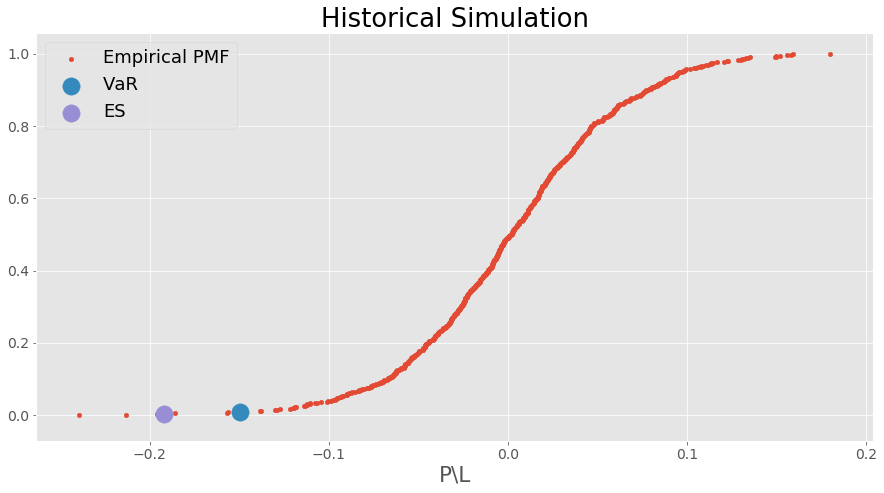

In [74]:
VaR_hist, ES_hist = historical_stock_VaR_ES(start, end, p_weights, alpha)

print(f'VaR: C вероятностью {1-alpha} портфель не потеряет за 10-дневный срок больше чем {round(VaR_hist * 100, 2)}% стоимости')
print(f'ES: Если портфель за 10 дней будет терять больше, чем {round(VaR_hist * 100, 2)}% стоимости, то он в среднем потеряет {round(ES_hist*100, 2)}%')